In [58]:
import yfinance as yf
df = yf.download('005930.KS',
                     start='2022-01-01',
                     end='2022-05-31') # 005930 : 삼성전자 주가

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,78295.289062,12427416
2022-01-05,78800.0,79000.0,76400.0,77400.0,77001.976562,25470640
2022-01-06,76700.0,77600.0,76600.0,76900.0,76504.546875,12931954
2022-01-07,78100.0,78400.0,77400.0,78300.0,77897.343750,15163757
2022-01-10,78100.0,78100.0,77100.0,78000.0,77598.890625,9947422


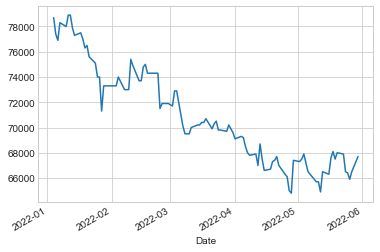

In [59]:
# data check
fig = df['Close'].plot()

In [60]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
plt.style.use('seaborn-whitegrid')

In [61]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

In [62]:
df['Volume'] = df['Volume'].astype(float)
del df['Volume']

In [63]:
df.head()

,Open,High,Low,Close,Adj Close
Date,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,78295.289062
2022-01-05,78800.0,79000.0,76400.0,77400.0,77001.976562
2022-01-06,76700.0,77600.0,76600.0,76900.0,76504.546875
2022-01-07,78100.0,78400.0,77400.0,78300.0,77897.343750
2022-01-10,78100.0,78100.0,77100.0,78000.0,77598.890625


In [64]:
X = df.drop('Close', axis=1) # X, y 분리
y = df[['Close']]

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:79, :]
X_test = X_ss[79:, :]

y_train = y_ms[:79, :]
y_test = y_ms[79:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (79, 4) (79, 1)
Testing Shape : (19, 4) (19, 1)


In [66]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

# print('Training Shape :', X_train.shape, y_train.shape)
# print('Testing Shape :', X_test.shape, y_test.shape)

In [67]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (79, 4) (79, 1)
Testing Shape : (19, 4) (19, 1)


## LSTM

In [68]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스
        self.num_layers = num_layers # LSTM 계층 개수
        self.input_size = input_size  # 입력 크기(컬럼 개수)
        self.hidden_size = hidden_size # 은닉층의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm 계층
        self.fc_1 =  nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉상태 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태 초기화
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터 형태를 1차원으로 조정
        out = self.relu(hn)
        out = self.fc_1(out) 
        out = self.relu(out) 
        out = self.fc(out)
        return out

In [71]:
num_epochs = 1000
lr = 0.0001

input_size=4 # 칼럼 개수
hidden_size=2 # 은닉층 유닛 개수
num_layers=1 # LSTM 계층 개수

num_classes=1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [72]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 오차 계싼
    loss.backward() # 기울기 계산
    
    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.19017
Epoch : 100, loss : 0.08589
Epoch : 200, loss : 0.07045
Epoch : 300, loss : 0.06684
Epoch : 400, loss : 0.06242
Epoch : 500, loss : 0.05652
Epoch : 600, loss : 0.04854
Epoch : 700, loss : 0.03837
Epoch : 800, loss : 0.02709
Epoch : 900, loss : 0.01657


In [73]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

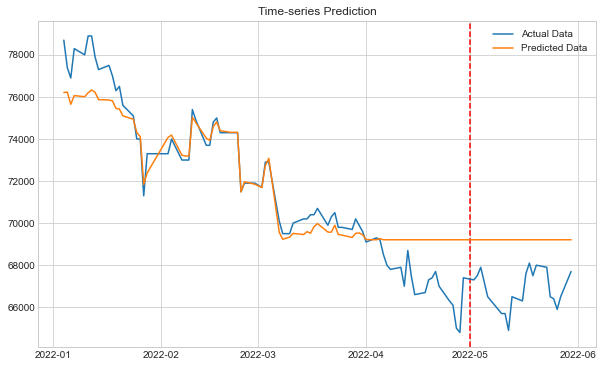

In [74]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

---

## GRU

In [75]:
class GRU(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(GRU, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,
                         num_layers=num_layers,batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [76]:
num_epochs = 1000
learning_rate = 0.0001

input_size=4
hidden_size=2
num_layers=1

num_classes=1
model=GRU(num_classes,input_size,hidden_size,num_layers,X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [77]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.21315
Epoch : 100, loss : 0.11704
Epoch : 200, loss : 0.07747
Epoch : 300, loss : 0.05075
Epoch : 400, loss : 0.03057
Epoch : 500, loss : 0.01790
Epoch : 600, loss : 0.01137
Epoch : 700, loss : 0.00848
Epoch : 800, loss : 0.00697
Epoch : 900, loss : 0.00587


In [78]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

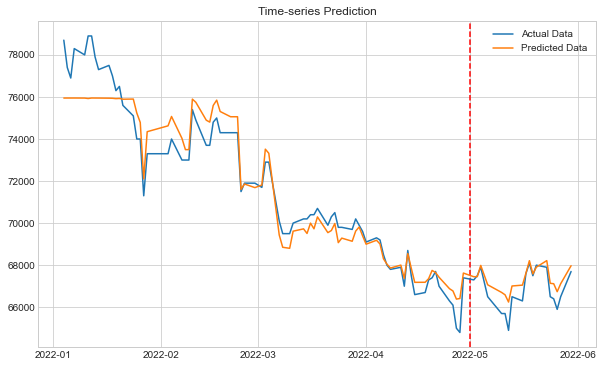

In [79]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['Close'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()